In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../')

In [3]:
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from symspellpy.symspellpy import SymSpell
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.sentiment import SentimentIntensityAnalyzer

from src.llm_preprocessing import generate_bigram_decision

In [4]:
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_colwidth', None)

In [5]:
sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
dictionary_path = 'data/dictionaries/frequency_dictionary_en_82_765.txt'
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)

True

In [6]:
df_pre_eda = pd.read_csv('data/processed/preprocessed_train.csv')
df = df_pre_eda.copy()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 587 entries, 0 to 586
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   text               587 non-null    object 
 1   target             587 non-null    float64
 2   has_number         587 non-null    bool   
 3   has_rating_number  587 non-null    bool   
 4   final_text         586 non-null    object 
 5   bert_text          587 non-null    object 
dtypes: bool(2), float64(1), object(3)
memory usage: 19.6+ KB


In [8]:
df.head(5)

,text,target,has_number,has_rating_number,final_text,bert_text
0,"judging from previous posts this used to be a good place , but not any longer .",0.0,False,False,judge previous post use good place long,"judging from previous posts this used to be a good place , but not any longer ."
1,"we , there were four of us , arrived at noon - the place was empty - and the staff acted like we were imposing on them and they were very rude .",0.0,False,False,four arrive noon place empty staff act like impose rude,"we , there were four of us , arrived at noon - the place was empty - and the staff acted like we were imposing on them and they were very rude ."
2,"they never brought us complimentary noodles , ignored repeated requests for sugar , and threw our dishes on the table .",0.0,False,False,never bring complimentary noodle ignore repeat request sugar throw dish table,"they never brought us complimentary noodles , ignored repeated requests for sugar , and threw our dishes on the table ."
3,the food was lousy - too sweet or too salty and the portions tiny .,0.0,False,False,food lousy sweet salty portion tiny,the food was lousy - too sweet or too salty and the portions tiny .
4,"after all that , they complained to me about the small tip .",0.0,False,False,complain small tip,"after all that , they complained to me about the small tip ."


In [9]:
df[df['final_text'].isnull()]

,text,target,has_number,has_rating_number,final_text,bert_text
415,10,1.0,True,True,NaN,10


In [10]:
# Removing the missing value for the EDA
df = df.loc[~df['final_text'].isnull()]

# EDA

## Target balance

In [11]:
df['target'].value_counts(normalize=True)

target
1.0    0.738908
0.0    0.261092
Name: proportion, dtype: float64

<Axes: xlabel='target', ylabel='count'>

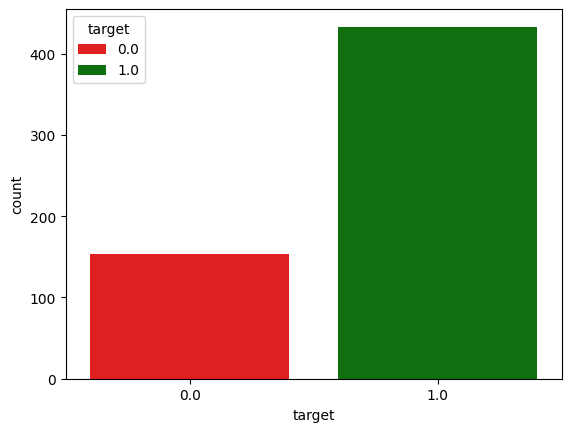

In [12]:
sns.countplot(x="target", data=df, hue='target', palette=["red", "green"])

### Top words

In [13]:
def get_top_words(data, n=20):
    all_words = " ".join(data).split()
    return Counter(all_words).most_common(n)

print("\nTop words for class 0:")
print(get_top_words(df[df['target'] == 0]['final_text']))

print("\nTop words for class 1:")
print(get_top_words(df[df['target'] == 1]['final_text']))


Top words for class 0:
[('food', 22), ('place', 18), ('service', 16), ('good', 15), ('restaurant', 13), ('go', 13), ('!', 11), ('time', 11), ('get', 11), ('back', 10), ('eat', 10), ('like', 9), ('table', 9), ('make', 9), ('bad', 9), ('order', 9), ('rude', 8), ('ask', 8), ('thing', 8), ('thai', 7)]

Top words for class 1:
[('food', 79), ('!', 71), ('great', 67), ('good', 66), ('service', 52), ('place', 43), ('go', 39), ('restaurant', 34), ('delicious', 29), ('recommend', 26), ('always', 24), ('price', 23), ('excellent', 22), ('try', 20), ('pizza', 20), ('well', 19), ('get', 19), ('wine', 18), ('nice', 18), ('time', 16)]


In [14]:
def plot_top_words_side_by_side_normalized(counter_0, counter_1, total_words_0, total_words_1, title_0='Class 0', title_1='Class 1'):
    # Normalize
    freq_df_0 = pd.DataFrame(counter_0, columns=['word', 'count'])
    freq_df_0['freq_percent'] = freq_df_0['count'] / total_words_0 * 100

    freq_df_1 = pd.DataFrame(counter_1, columns=['word', 'count'])
    freq_df_1['freq_percent'] = freq_df_1['count'] / total_words_1 * 100

    fig, axes = plt.subplots(1, 2, figsize=(15,6), sharey=True)

    axes[0].bar(freq_df_0['word'], freq_df_0['freq_percent'])
    axes[0].set_title(title_0)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].set_ylabel('Frequency (%)')

    axes[1].bar(freq_df_1['word'], freq_df_1['freq_percent'])
    axes[1].set_title(title_1)
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

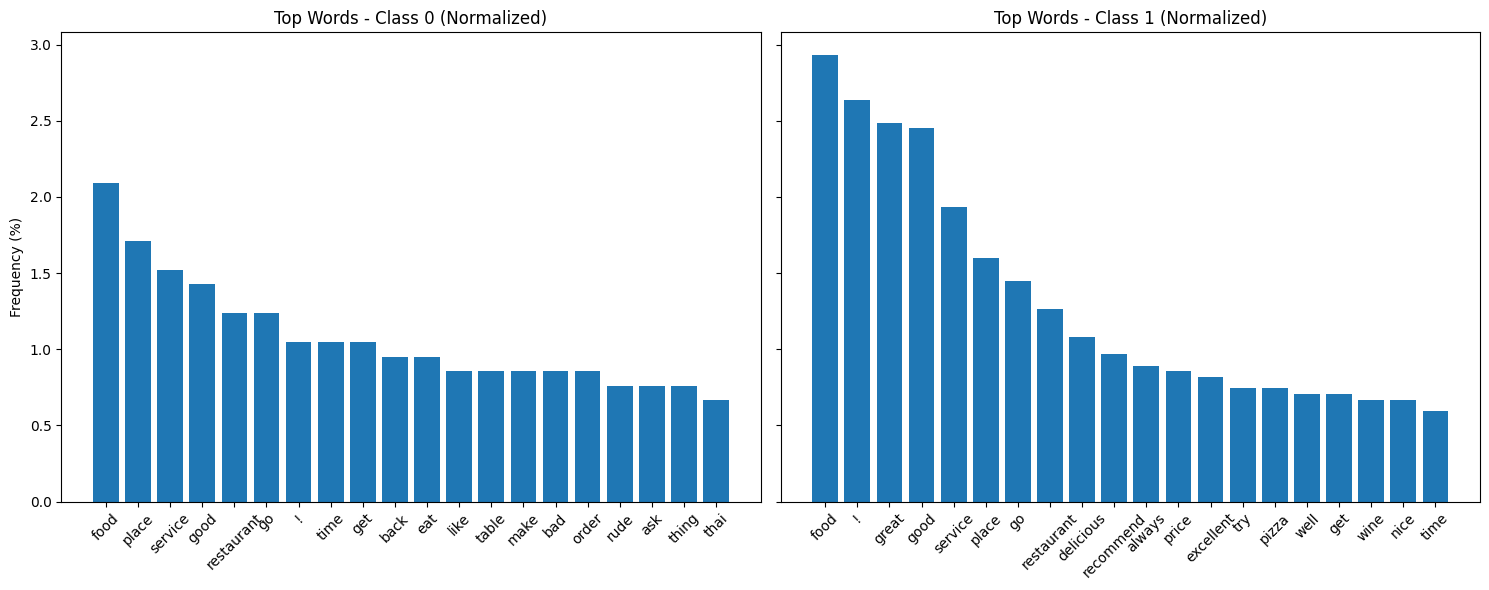

In [15]:
# Total words per class (for normalization)

top_words_0 = get_top_words(df[df['target'] == 0]['final_text'])
top_words_1 = get_top_words(df[df['target'] == 1]['final_text'])

total_words_0 = df[df['target'] == 0]['final_text'].apply(lambda x: len(x.split())).sum()
total_words_1 = df[df['target'] == 1]['final_text'].apply(lambda x: len(x.split())).sum()

plot_top_words_side_by_side_normalized(
    top_words_0, top_words_1,
    total_words_0, total_words_1,
    'Top Words - Class 0 (Normalized)', 'Top Words - Class 1 (Normalized)'
)

Distribution shows that words like food, place and service are important for both classes. Those words are important drivers, but alone they dont say much. Bigram analysis should provide better insights

### Bigrams - CountVectorizer

In [16]:
n_max = 20

In [17]:
# Example for bigrams (2-grams)
vectorizer = CountVectorizer(ngram_range=(2,2), max_features=n_max)
X_ngrams = vectorizer.fit_transform(df['final_text'])

# Show most common bigrams
bigrams = vectorizer.get_feature_names_out()
counts = X_ngrams.sum(axis=0).A1
bigrams_freq = sorted(zip(bigrams, counts), key=lambda x: x[1], reverse=True)

In [18]:
def get_top_ngrams(corpus, ngram_range=(2,2), top_n=n_max):
    vectorizer = CountVectorizer(ngram_range=ngram_range, max_features=10000)
    X_ngrams = vectorizer.fit_transform(corpus)
    ngrams = vectorizer.get_feature_names_out()
    counts = X_ngrams.sum(axis=0).A1
    return sorted(zip(ngrams, counts), key=lambda x: x[1], reverse=True)[:top_n]

In [19]:
def plot_top_ngrams_side_by_side(ngrams_0, ngrams_1, title_0='Class 0', title_1='Class 1'):
    df_0 = pd.DataFrame(ngrams_0, columns=['ngram', 'count'])
    df_1 = pd.DataFrame(ngrams_1, columns=['ngram', 'count'])
    
    fig, axes = plt.subplots(1, 2, figsize=(15,6), sharey=True)
    
    axes[0].bar(df_0['ngram'], df_0['count'])
    axes[0].set_title(title_0)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].set_ylabel('Frequency')

    axes[1].bar(df_1['ngram'], df_1['count'])
    axes[1].set_title(title_1)
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

In [20]:
# Get top 20 bigrams for each class
top_ngrams_0 = get_top_ngrams(df[df['target'] == 0]['final_text'], top_n=n_max)
top_ngrams_1 = get_top_ngrams(df[df['target'] == 1]['final_text'], top_n=n_max)

# Convert to DataFrames
df_ngrams_0 = pd.DataFrame(top_ngrams_0, columns=['bigram_0', 'frequency_0'])
df_ngrams_1 = pd.DataFrame(top_ngrams_1, columns=['bigram_1', 'frequency_1'])

# Combine side by side (reset index to align properly)
df_bigrams_combined_cv = pd.concat([df_ngrams_0.reset_index(drop=True), df_ngrams_1.reset_index(drop=True)], axis=1)

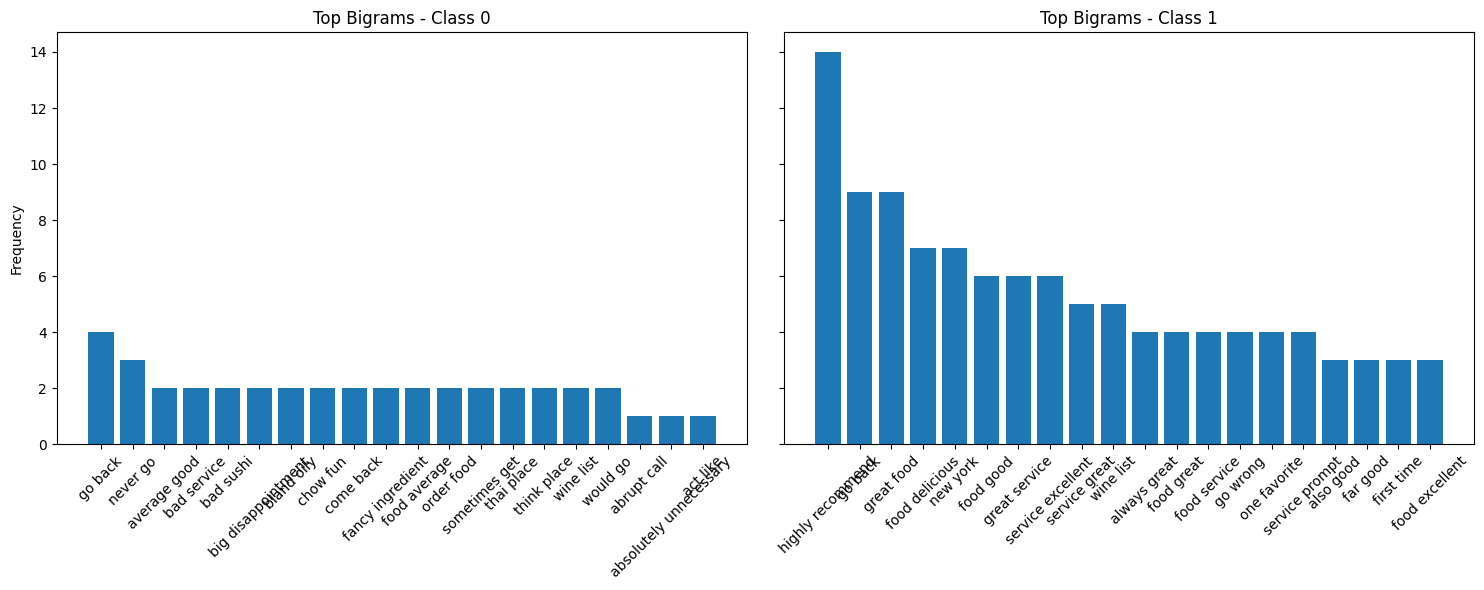

In [21]:
top_bigrams_0 = get_top_ngrams(df[df['target'] == 0]['final_text'])
top_bigrams_1 = get_top_ngrams(df[df['target'] == 1]['final_text'])

plot_top_ngrams_side_by_side(top_bigrams_0, top_bigrams_1, 'Top Bigrams - Class 0', 'Top Bigrams - Class 1')

In [22]:
df_bigrams_combined_cv.head()

,bigram_0,frequency_0,bigram_1,frequency_1
0,go back,4,highly recommend,14
1,never go,3,go back,9
2,average good,2,great food,9
3,bad service,2,food delicious,7
4,bad sushi,2,new york,7


### Bigrams - CollocationFinder

In [23]:
min_freq = 2

In [24]:
def get_pmi_bigrams_df(text_list, top_n=n_max, min_freq=min_freq):
    words = " ".join(text_list).split()
    finder = BigramCollocationFinder.from_words(words)
    finder.apply_freq_filter(min_freq)
    
    bigrams_pmi = []
    for bigram, freq in finder.ngram_fd.items():
        pmi_score = finder.score_ngram(BigramAssocMeasures().pmi, bigram[0], bigram[1])
        bigrams_pmi.append((f"{bigram[0]} {bigram[1]}", freq, pmi_score))
    
    df_pmi = pd.DataFrame(bigrams_pmi, columns=['bigram', 'frequency', 'pmi_score'])
    df_pmi = df_pmi.sort_values(by='pmi_score', ascending=False).head(top_n).reset_index(drop=True)
    
    return df_pmi

In [25]:
# Get PMI bigram tables for both classes
df_pmi_0 = get_pmi_bigrams_df(df[df['target'] == 0]['final_text'], top_n=n_max, min_freq=min_freq)
df_pmi_1 = get_pmi_bigrams_df(df[df['target'] == 1]['final_text'], top_n=n_max, min_freq=min_freq)

# Rename columns for clarity
df_pmi_0.columns = [f"{col}_0" for col in df_pmi_0.columns]
df_pmi_1.columns = [f"{col}_1" for col in df_pmi_1.columns]

# Combine side by side
df_pmi_combined = pd.concat([df_pmi_0, df_pmi_1], axis=1)

df_pmi_combined.head()

,bigram_0,frequency_0,pmi_score_0,bigram_1,frequency_1,pmi_score_1
0,fancy ingredient,2.0,9.038919,smith street,2,10.394999
1,wine list,2.0,9.038919,dal bukhara,2,10.394999
2,chow fun,2.0,8.453956,jekyll hyde,2,10.394999
3,big disappointment,2.0,7.868994,pleasantly surprised,2,10.394999
4,bland oily,2.0,7.453956,red eye,2,9.810036


### Bigram - combined

In [26]:
# Get top 50 bigrams by frequency
freq_bigrams = get_top_ngrams(df['final_text'], ngram_range=(2,2), top_n=50)
df_freq = pd.DataFrame(freq_bigrams, columns=['bigram', 'frequency'])

# Get top 50 bigrams by PMI
df_pmi = get_pmi_bigrams_df(df['final_text'], top_n=50, min_freq=2)

# Merge both on 'bigram' (inner join ensures only common bigrams)
df_combined = pd.merge(df_freq, df_pmi, on='bigram', how='outer').sort_values(['pmi_score', 'frequency_x'], ascending=[False, False]).reset_index(drop=True)

df_combined.head()

,bigram,frequency_x,frequency_y,pmi_score
0,dal bukhara,NaN,2.0,10.870750
1,jekyll hyde,NaN,2.0,10.870750
2,pleasantly surprised,NaN,2.0,10.870750
3,smith street,NaN,2.0,10.870750
4,red eye,NaN,2.0,10.285788


### Create bigram list

The dataset is small enough so bigram selection could be done manually, but gpt4 will be used to scalate the solution. In any case, manual analysis will be done in its answer

In [27]:
# df_combined['llm_keep_bigram'] = generate_bigram_decision(df_combined, model_name="gpt4")

In [28]:
# df_bigr_0 = df_combined.loc[df_combined['llm_keep_bigram']==0, 'bigram']
# df_bigr_1 = df_combined.loc[df_combined['llm_keep_bigram']==1, 'bigram']

In [29]:
# df_combined.loc[df_combined['llm_keep_bigram']==1, 'bigram'].unique()

In [30]:
gpt_bigram_list = ['dal bukhara', 'jekyll hyde', 'pleasantly surprised',
       'smith street', 'red eye', 'st bart', 'week ago',
       'cheeseburger huge', 'bland oily', 'melt mouth', 'shabu shabu',
       'top notch', 'goat cheese', 'shred cheese', 'write review',
       'new york', 'look forward', 'chow fun', 'lobster sandwich',
       'cream cheese', 'big disappointment', 'fast delivery',
       'tasting menu', 'one hour', 'large portion', 'last night',
       'well prepared', 'special occasion', 'wine list',
       'reasonable price', 'highly recommend', 'make point',
       'make reservation', 'price high', 'absolutely love', 'pizza nyc',
       'fish fresh', 'go back', 'great service', 'come back',
       'food service', 'go wrong', 'bad service', 'first time',
       'service impeccable']

In [31]:
# df_bigr_0.iloc[0:5]

In [32]:
add_bigram_list = ['great food', 'food delicious', 'service excellent', 'service great', 'food great', 'food average', 'food excellent', 'good meal', 'good restaurant', 'good wine', 'great place', 'never go', 'service good', 'service top']

In [33]:
# df_bigr_1.iloc[0:5]

In [34]:
remove_bigram_list = ['food service']

In [35]:
gpt_bigram_set = set(gpt_bigram_list)
remove_bigram_set = set(remove_bigram_list)
add_bigram_set = set(add_bigram_list)

# Apply removals and additions
final_bigram_set = (gpt_bigram_set - remove_bigram_set).union(add_bigram_set)

# Convert back to sorted list if needed
final_bigram_list = sorted(final_bigram_set)

In [36]:
print("Final selected bigrams:", final_bigram_list)

Final selected bigrams: ['absolutely love', 'bad service', 'big disappointment', 'bland oily', 'cheeseburger huge', 'chow fun', 'come back', 'cream cheese', 'dal bukhara', 'fast delivery', 'first time', 'fish fresh', 'food average', 'food delicious', 'food excellent', 'food great', 'go back', 'go wrong', 'goat cheese', 'good meal', 'good restaurant', 'good wine', 'great food', 'great place', 'great service', 'highly recommend', 'jekyll hyde', 'large portion', 'last night', 'lobster sandwich', 'look forward', 'make point', 'make reservation', 'melt mouth', 'never go', 'new york', 'one hour', 'pizza nyc', 'pleasantly surprised', 'price high', 'reasonable price', 'red eye', 'service excellent', 'service good', 'service great', 'service impeccable', 'service top', 'shabu shabu', 'shred cheese', 'smith street', 'special occasion', 'st bart', 'tasting menu', 'top notch', 'week ago', 'well prepared', 'wine list', 'write review']


### Trigram

While bigram analysis is mostly sufficient, some case like go back can still be misleading. Trigram can help in those cases

In [37]:
def get_top_trigrams(corpus, top_n=30):
    vectorizer = CountVectorizer(ngram_range=(3,3))
    X_ngrams = vectorizer.fit_transform(corpus)
    ngrams = vectorizer.get_feature_names_out()
    counts = X_ngrams.sum(axis=0).A1
    trigram_df = pd.DataFrame({'trigram': ngrams, 'frequency': counts})
    trigram_df = trigram_df[trigram_df['trigram'].str.contains('go back')]
    return trigram_df.sort_values('frequency', ascending=False).reset_index(drop=True)

df_trigrams_with_go_back = get_top_trigrams(df['final_text'])
print(df_trigrams_with_go_back)

              trigram  frequency
0       would go back          2
1       never go back          2
2  definitely go back          1
3        ever go back          1
4    go back heartily          1
5        go back soon          1
6       go back place          1
7   recommend go back          1
8        wait go back          1


In [38]:
trigram_list = sorted(set(df_trigrams_with_go_back['trigram'].unique()))

In [39]:
print("Final selected trigrams:", trigram_list)

Final selected bigrams: ['definitely go back', 'ever go back', 'go back heartily', 'go back place', 'go back soon', 'never go back', 'recommend go back', 'wait go back', 'would go back']


## Fine preprocessing

It is important to unify some similar bigram to remove redundancy and improve predictive power

In [40]:
bigram_group_mapping = {'food delicious': 'great_food',
                        'food excellent': 'great_food',
                        'food great': 'great_food',
                        'great food': 'great_food',
                        
                        'great service': 'great_service',
                        'service excellent': 'great_service',
                        'service good': 'great_service',
                        'service great': 'great_service',
                        'service impeccable': 'great_service',
                        'service top': 'great_service'
                       }

In [41]:
[bigram for bigram in final_bigram_list if 'good' in bigram]

['good meal', 'good restaurant', 'good wine', 'service good']

In [42]:
[bigram for bigram in final_bigram_list if 'food' in bigram]

['food average',
 'food delicious',
 'food excellent',
 'food great',
 'great food']

In [43]:
[bigram for bigram in final_bigram_list if 'service' in bigram]

['bad service',
 'great service',
 'service excellent',
 'service good',
 'service great',
 'service impeccable',
 'service top']

In [44]:
[bigram for bigram in final_bigram_list if 'restaurant' in bigram]

['good restaurant']

In [45]:
[bigram for bigram in final_bigram_list if 'price' in bigram]

['price high', 'reasonable price']

In [46]:
trigram_group_mapping = {'definitely go back': 'go_back',
                         'go back heartily': 'go_back',
                         'go back place': 'go_back', 
                         'go back soon': 'go_back', 
                         'recommend go back': 'go_back', 
                         'wait go back': 'go_back',
                         'would go back': 'go_back',

                         'ever go back': 'dont_go_back' ,
                         'never go back': 'dont_go_back', 
                       }

In [47]:
def enrich_text_full(text, trigram_group_mapping, bigram_group_mapping, trigram_list, bigram_list):
    # 1. Replace trigram group mappings (strong semantic overrides)
    for trigram, unified in trigram_group_mapping.items():
        text = text.replace(trigram, unified)
    
    # 2. Replace bigram group mappings
    for bigram, unified in bigram_group_mapping.items():
        text = text.replace(bigram, unified)
    
    # 3. Replace remaining specific trigrams as unigrams
    for trigram in trigram_list:
        text = text.replace(trigram, trigram.replace(' ', '_'))
    
    # 4. Replace remaining specific bigrams as unigrams
    for bigram in bigram_list:
        text = text.replace(bigram, bigram.replace(' ', '_'))
    
    return text

In [48]:
df['final_text_enriched'] = df['final_text'].apply(lambda x: enrich_text_full(x, trigram_group_mapping, bigram_group_mapping, trigram_list, final_bigram_list))

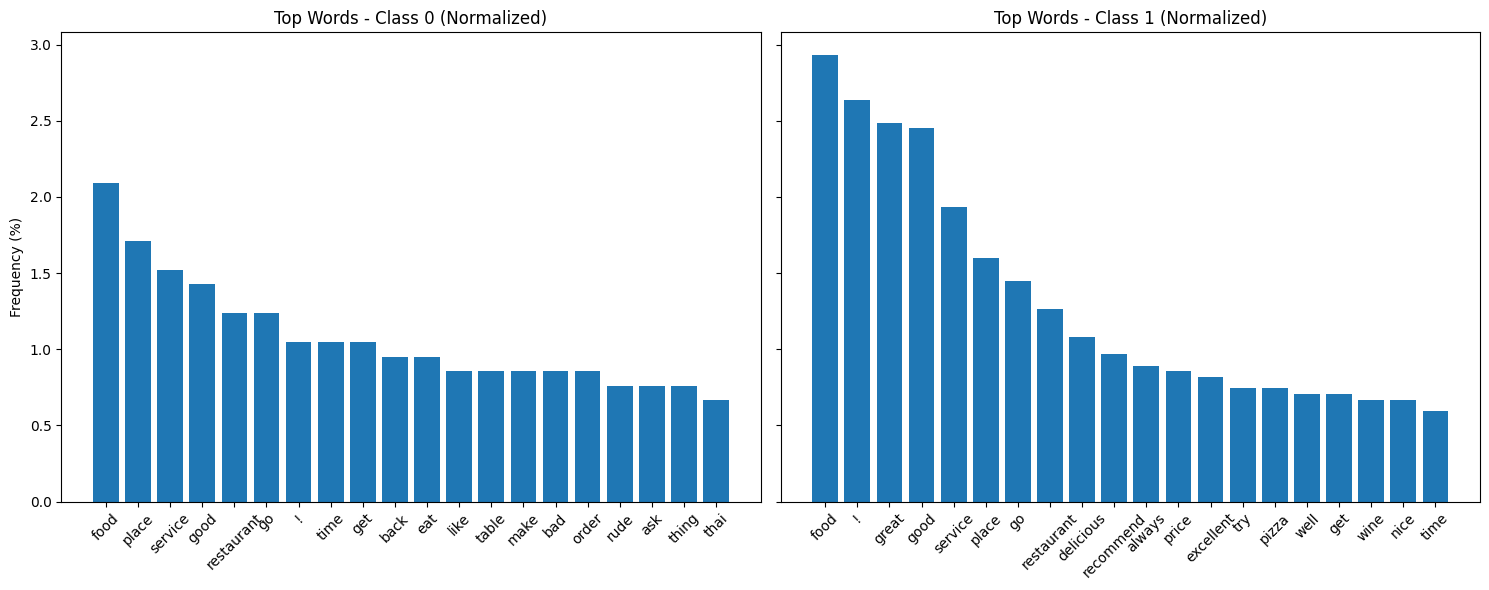

In [49]:
# Total words per class (for normalization)

top_words_0 = get_top_words(df[df['target'] == 0]['final_text'])
top_words_1 = get_top_words(df[df['target'] == 1]['final_text'])

total_words_0 = df[df['target'] == 0]['final_text'].apply(lambda x: len(x.split())).sum()
total_words_1 = df[df['target'] == 1]['final_text'].apply(lambda x: len(x.split())).sum()

plot_top_words_side_by_side_normalized(
    top_words_0, top_words_1,
    total_words_0, total_words_1,
    'Top Words - Class 0 (Normalized)', 'Top Words - Class 1 (Normalized)'
)

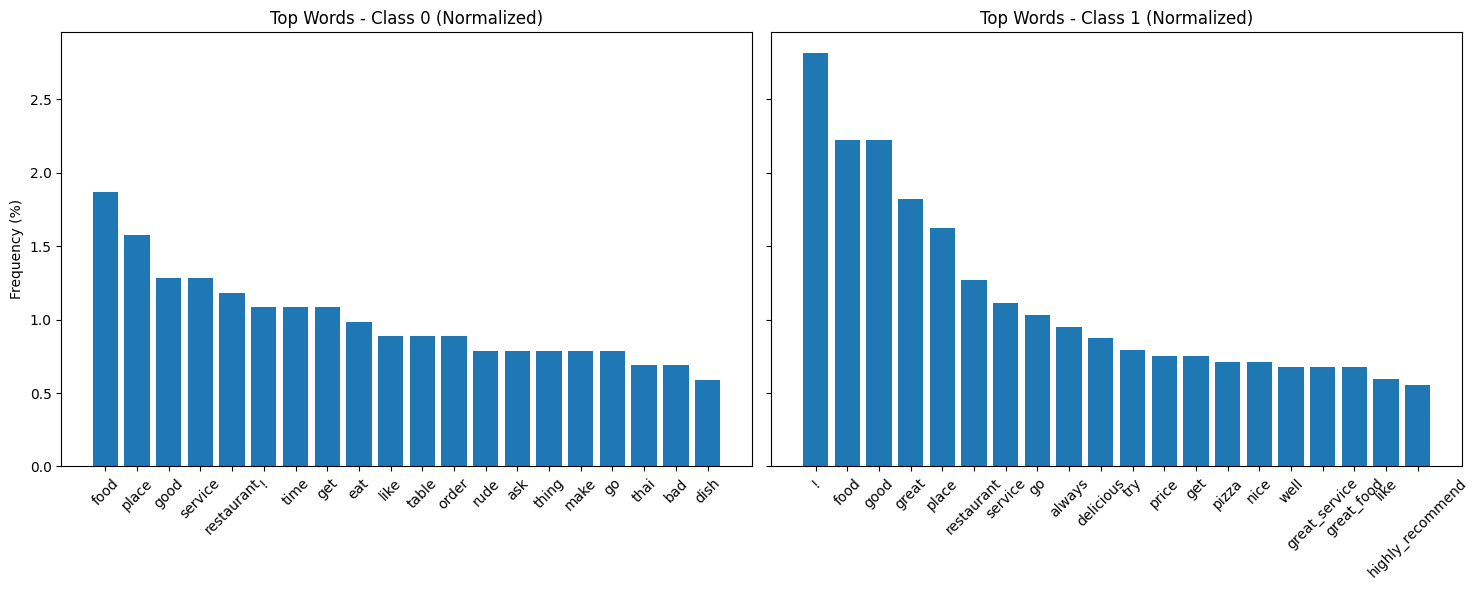

In [50]:
# Total words per class (for normalization)

top_words_0 = get_top_words(df[df['target'] == 0]['final_text_enriched'])
top_words_1 = get_top_words(df[df['target'] == 1]['final_text_enriched'])

total_words_0 = df[df['target'] == 0]['final_text_enriched'].apply(lambda x: len(x.split())).sum()
total_words_1 = df[df['target'] == 1]['final_text_enriched'].apply(lambda x: len(x.split())).sum()

plot_top_words_side_by_side_normalized(
    top_words_0, top_words_1,
    total_words_0, total_words_1,
    'Top Words - Class 0 (Normalized)', 'Top Words - Class 1 (Normalized)'
)

Bigram and trigam analysis reduced the problem. Percentage of words such as food and service reduced, which should help when modelling

## Text length

In [51]:
df['text_length'] = df['final_text'].apply(lambda x: len(x))
df['n_tokens'] = df['final_text_enriched'].apply(lambda x: len(x.split()))

In [52]:
df.groupby('target')['text_length'].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0.0,153.0,42.764706,23.302294,4.0,25.0,39.0,56.0,124.0
1.0,433.0,39.678984,22.993778,2.0,22.0,34.0,53.0,132.0


In [53]:
df.groupby('target')['n_tokens'].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0.0,153.0,6.640523,3.770757,1.0,4.0,6.0,8.0,21.0
1.0,433.0,5.829099,3.401169,1.0,3.0,5.0,8.0,20.0


## Sentiment analysis

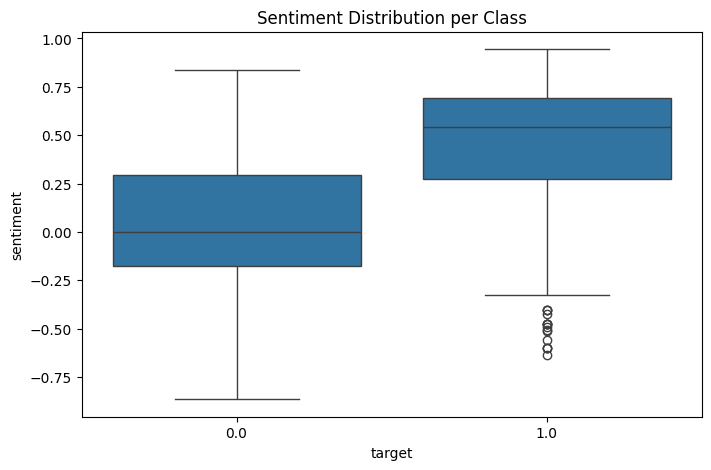

In [54]:
sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['final_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

df.groupby('target')['sentiment'].describe()

# Optional plot
import seaborn as sns

plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='target', y='sentiment')
plt.title('Sentiment Distribution per Class')
plt.show()

# Save final dataframe

In [55]:
df.drop(columns=['final_text'], inplace=True)

In [56]:
df.to_csv('data/processed/final_processed_train.csv', index=False)

In [57]:
df

,text,target,has_number,has_rating_number,bert_text,final_text_enriched,text_length,n_tokens,sentiment
0,"judging from previous posts this used to be a good place , but not any longer .",0.0,False,False,"judging from previous posts this used to be a good place , but not any longer .",judge previous post use good place long,39,7,0.4404
1,"we , there were four of us , arrived at noon - the place was empty - and the staff acted like we were imposing on them and they were very rude .",0.0,False,False,"we , there were four of us , arrived at noon - the place was empty - and the staff acted like we were imposing on them and they were very rude .",four arrive noon place empty staff act like impose rude,55,10,-0.5423
2,"they never brought us complimentary noodles , ignored repeated requests for sugar , and threw our dishes on the table .",0.0,False,False,"they never brought us complimentary noodles , ignored repeated requests for sugar , and threw our dishes on the table .",never bring complimentary noodle ignore repeat request sugar throw dish table,77,11,-0.6002
3,the food was lousy - too sweet or too salty and the portions tiny .,0.0,False,False,the food was lousy - too sweet or too salty and the portions tiny .,food lousy sweet salty portion tiny,35,6,-0.1280
4,"after all that , they complained to me about the small tip .",0.0,False,False,"after all that , they complained to me about the small tip .",complain small tip,18,3,-0.3612
...,...,...,...,...,...,...,...,...,...
582,mizu is the japenese find in grammercy .,1.0,False,False,mizu is the japenese find in grammercy .,mizu japanese find gramercy,27,4,0.0000
583,"while their kitchen food is delicious , their sushi is out of this world .",1.0,False,False,"while their kitchen food is delicious , their sushi is out of this world .",kitchen great_food sushi world,34,4,0.5719
584,mizu is home to creative and unique rolls not to found anywhere else .,1.0,False,False,mizu is home to creative and unique rolls not to found anywhere else .,mizu home creative unique roll find anywhere else,49,8,0.4404
585,"not only is the cuisine the best around , the service has always been attentive and charming .",1.0,False,False,"not only is the cuisine the best around , the service has always been attentive and charming .",cuisine good around service always attentive charming,53,7,0.7717
